=== 2D TV Denoising Demo ===


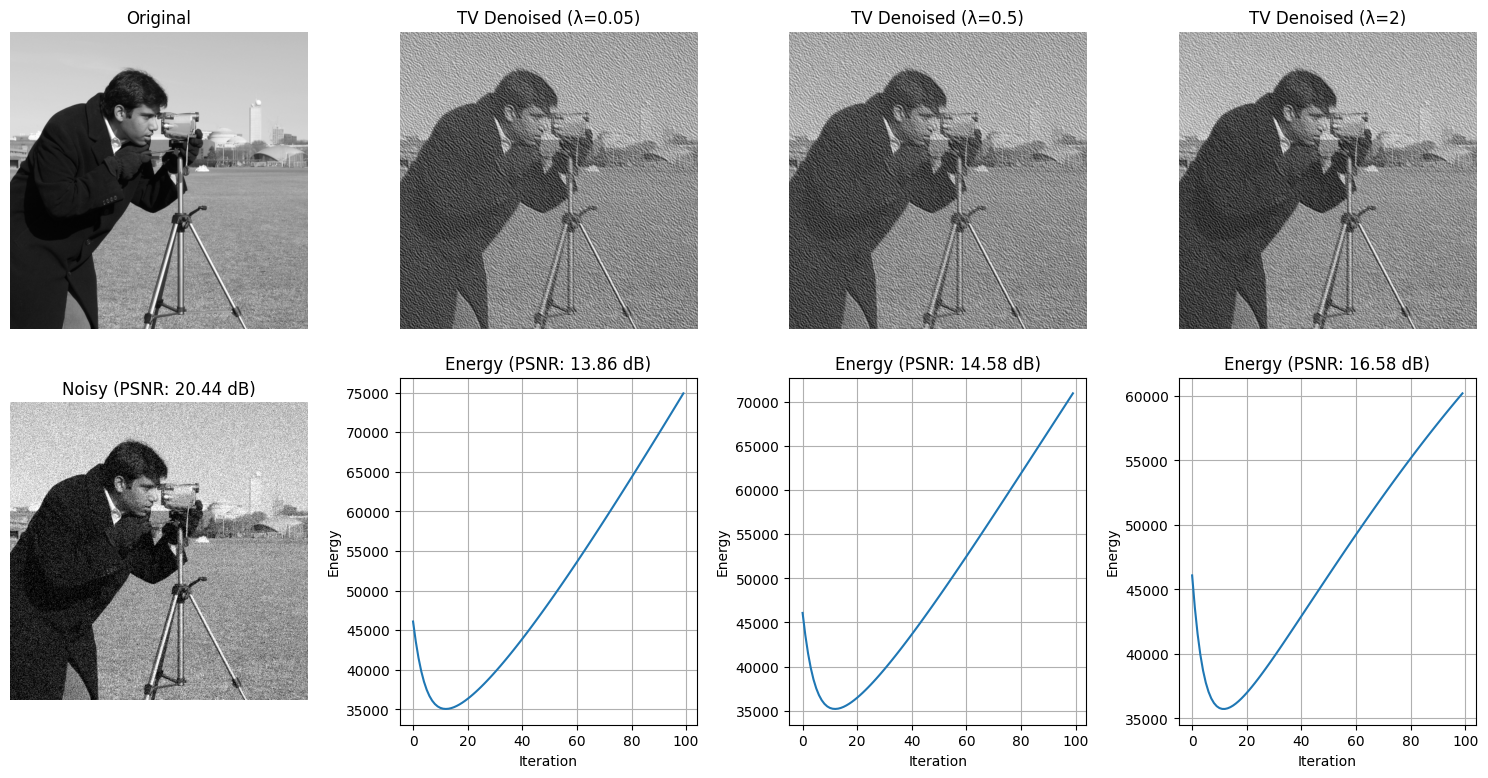


=== 3D TV Denoising Demo ===
Iteration 10: Energy = 15025.112977, Relative change = 9.360016e-03
Iteration 20: Energy = 10201.802096, Relative change = 5.792728e-03
Iteration 30: Energy = 9247.337201, Relative change = 5.195975e-03
Iteration 40: Energy = 9674.794883, Relative change = 5.087925e-03
Iteration 50: Energy = 10722.287730, Relative change = 5.119496e-03


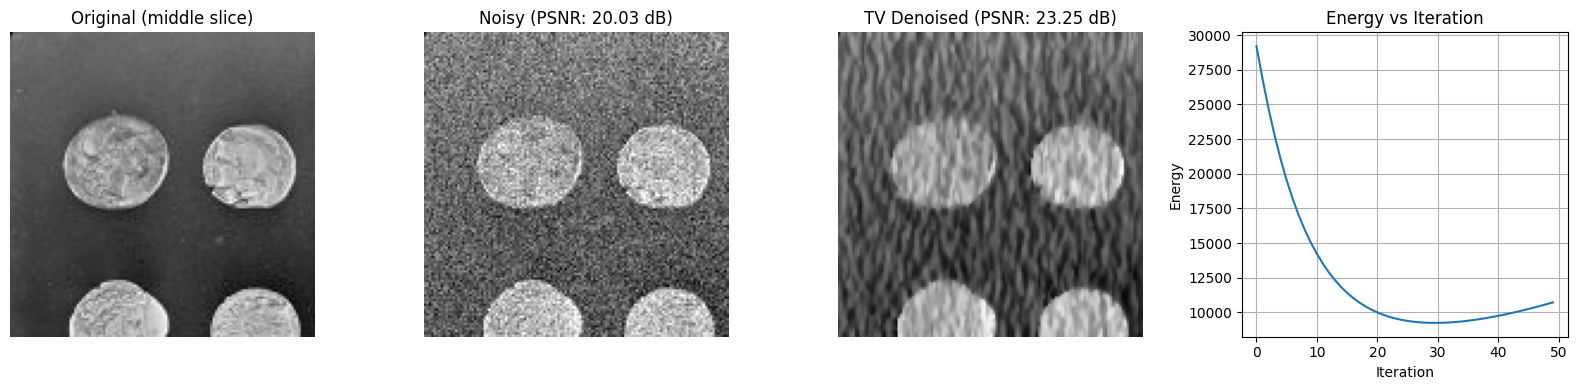


=== Parameter Sensitivity Analysis ===
λ = 0.010: PSNR = 16.96 dB, TV = 3304.28
λ = 0.011: PSNR = 16.96 dB, TV = 3304.12
λ = 0.012: PSNR = 16.96 dB, TV = 3303.95
λ = 0.013: PSNR = 16.96 dB, TV = 3303.78
λ = 0.015: PSNR = 16.96 dB, TV = 3303.47
λ = 0.016: PSNR = 16.96 dB, TV = 3303.27
λ = 0.017: PSNR = 16.96 dB, TV = 3303.11
λ = 0.019: PSNR = 16.96 dB, TV = 3302.86
λ = 0.021: PSNR = 16.96 dB, TV = 3302.57
λ = 0.023: PSNR = 16.96 dB, TV = 3302.25
λ = 0.025: PSNR = 16.96 dB, TV = 3301.90
λ = 0.028: PSNR = 16.96 dB, TV = 3301.51
λ = 0.031: PSNR = 16.97 dB, TV = 3301.03
λ = 0.034: PSNR = 16.97 dB, TV = 3300.60
λ = 0.037: PSNR = 16.97 dB, TV = 3300.06
λ = 0.040: PSNR = 16.97 dB, TV = 3299.52
λ = 0.044: PSNR = 16.97 dB, TV = 3298.91
λ = 0.049: PSNR = 16.97 dB, TV = 3298.19
λ = 0.053: PSNR = 16.98 dB, TV = 3297.43
λ = 0.059: PSNR = 16.98 dB, TV = 3296.52
λ = 0.064: PSNR = 16.98 dB, TV = 3295.64
λ = 0.071: PSNR = 16.98 dB, TV = 3294.76
λ = 0.077: PSNR = 16.99 dB, TV = 3293.71
λ = 0.085: PSNR =

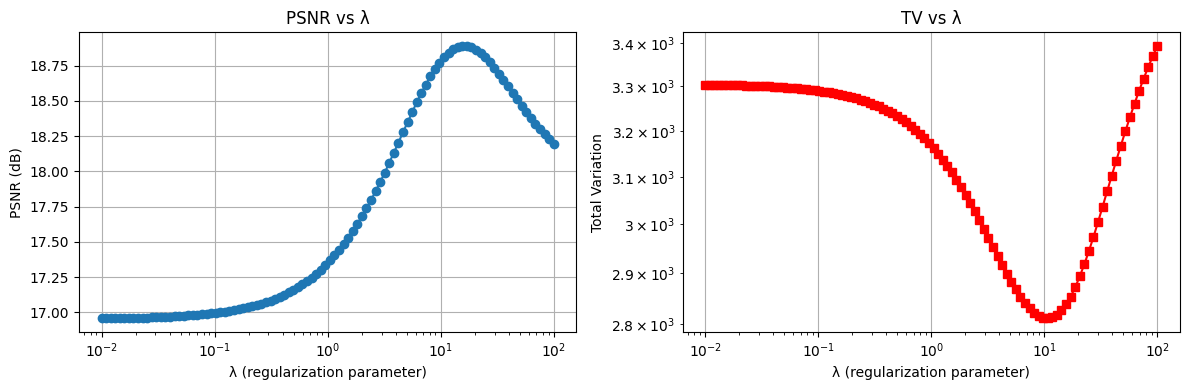

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage import data, util
import warnings
warnings.filterwarnings('ignore')

class TVDenoising:
    """
    Total Variation (TV) Denoising implementation using the ROF model.
    
    This implements the Rudin-Osher-Fatemi model for image denoising using
    gradient descent to solve the Euler-Lagrange equation.
    """
    
    def __init__(self, lambda_param=2, epsilon=1e-10, max_iter=5000, dt=0.005):
        """
        Initialize TV denoising parameters.
        
        Parameters:
        -----------
        lambda_param : float
            Regularization parameter balancing data fidelity vs smoothness
        epsilon : float
            Small regularization constant to avoid division by zero
        max_iter : int
            Maximum number of iterations
        dt : float
            Time step for gradient descent (must satisfy stability condition)
        """
        self.lambda_param = lambda_param
        self.epsilon = epsilon
        self.max_iter = max_iter
        self.dt = dt
    
    def gradient_2d(self, u):
        """
        Compute gradient of 2D image using forward differences.
        
        Parameters:
        -----------
        u : ndarray
            2D image array
            
        Returns:
        --------
        grad_x, grad_y : ndarray
            Gradient components in x and y directions
        """
        grad_x = np.zeros_like(u)
        grad_y = np.zeros_like(u)
        
        # Forward differences with Neumann boundary conditions
        grad_x[:, :-1] = u[:, 1:] - u[:, :-1]
        grad_x[:, -1] = 0  # Neumann boundary condition
        
        grad_y[:-1, :] = u[1:, :] - u[:-1, :]
        grad_y[-1, :] = 0  # Neumann boundary condition
        
        return grad_x, grad_y
    
    def gradient_3d(self, u):
        """
        Compute gradient of 3D image using forward differences.
        
        Parameters:
        -----------
        u : ndarray
            3D image array
            
        Returns:
        --------
        grad_x, grad_y, grad_z : ndarray
            Gradient components in x, y, and z directions
        """
        grad_x = np.zeros_like(u)
        grad_y = np.zeros_like(u)
        grad_z = np.zeros_like(u)
        
        # Forward differences with Neumann boundary conditions
        grad_x[:, :, :-1] = u[:, :, 1:] - u[:, :, :-1]
        grad_y[:, :-1, :] = u[:, 1:, :] - u[:, :-1, :]
        grad_z[:-1, :, :] = u[1:, :, :] - u[:-1, :, :]
        
        return grad_x, grad_y, grad_z
    
    def divergence_2d(self, px, py):
        """
        Compute divergence of 2D vector field using backward differences.
        
        Parameters:
        -----------
        px, py : ndarray
            Components of 2D vector field
            
        Returns:
        --------
        div : ndarray
            Divergence of the vector field
        """
        div_x = np.zeros_like(px)
        div_y = np.zeros_like(py)
        
        # Backward differences
        div_x[1:, :] = px[1:, :] - px[:-1, :]
        div_x[0, :] = px[0, :]
        
        div_y[:, 1:] = py[:, 1:] - py[:, :-1]
        div_y[:, 0] = py[:, 0]
        
        return div_x + div_y
    
    def divergence_3d(self, px, py, pz):
        """
        Compute divergence of 3D vector field using backward differences.
        
        Parameters:
        -----------
        px, py, pz : ndarray
            Components of 3D vector field
            
        Returns:
        --------
        div : ndarray
            Divergence of the vector field
        """
        div_x = np.zeros_like(px)
        div_y = np.zeros_like(py)
        div_z = np.zeros_like(pz)
        
        # Backward differences
        div_x[1:, :, :] = px[1:, :, :] - px[:-1, :, :]
        div_x[0, :, :] = px[0, :, :]
        
        div_y[:, 1:, :] = py[:, 1:, :] - py[:, :-1, :]
        div_y[:, 0, :] = py[:, 0, :]
        
        div_z[:, :, 1:] = pz[:, :, 1:] - pz[:, :, :-1]
        div_z[:, :, 0] = pz[:, :, 0]
        
        return div_x + div_y + div_z
    
    def tv_norm(self, u):
        """
        Compute the total variation norm of an image.
        
        Parameters:
        -----------
        u : ndarray
            Image array (2D or 3D)
            
        Returns:
        --------
        tv : float
            Total variation norm
        """
        if u.ndim == 2:
            grad_x, grad_y = self.gradient_2d(u)
            grad_magnitude = np.sqrt(grad_x**2 + grad_y**2 + self.epsilon**2)
        elif u.ndim == 3:
            grad_x, grad_y, grad_z = self.gradient_3d(u)
            grad_magnitude = np.sqrt(grad_x**2 + grad_y**2 + grad_z**2 + self.epsilon**2)
        else:
            raise ValueError("Input must be 2D or 3D array")
        
        return np.sum(grad_magnitude)
    
    def denoise_2d(self, f, verbose=True):
        """
        Denoise a 2D image using TV regularization.
        
        Parameters:
        -----------
        f : ndarray
            Noisy input image (2D)
        verbose : bool
            Whether to print progress information
            
        Returns:
        --------
        u : ndarray
            Denoised image
        energy_history : list
            Energy values during optimization
        """
        u = f.copy().astype(np.float64)
        energy_history = []
        
        for i in range(self.max_iter):
            # Compute gradient
            grad_x, grad_y = self.gradient_2d(u)
            
            # Compute gradient magnitude with regularization
            grad_magnitude = np.sqrt(grad_x**2 + grad_y**2 + self.epsilon**2)
            
            # Normalize gradient (compute p = ∇u/|∇u|)
            px = grad_x / grad_magnitude
            py = grad_y / grad_magnitude
            
            # Compute divergence of normalized gradient
            div_p = self.divergence_2d(px, py)
            
            # Update u using gradient descent
            # ∂u/∂t = div(∇u/|∇u|) - λ(u-f)
            u_new = u + self.dt * (div_p - self.lambda_param * (u - f))
            
            # Compute energy
            data_fidelity = 0.5 * np.sum((u - f)**2)
            tv_term = self.tv_norm(u)
            energy = self.lambda_param * data_fidelity + tv_term
            energy_history.append(energy)
            
            # Check convergence
            relative_change = np.linalg.norm(u_new - u) / np.linalg.norm(u)
            
            if verbose and (i + 1) % 10 == 0:
                print(f"Iteration {i+1}: Energy = {energy:.6f}, "
                      f"Relative change = {relative_change:.6e}")
            
            if relative_change < 1e-6:
                if verbose:
                    print(f"Converged after {i+1} iterations")
                break
            
            u = u_new
        
        return u, energy_history
    
    def denoise_3d(self, f, verbose=True):
        """
        Denoise a 3D image using TV regularization.
        
        Parameters:
        -----------
        f : ndarray
            Noisy input image (3D)
        verbose : bool
            Whether to print progress information
            
        Returns:
        --------
        u : ndarray
            Denoised image
        energy_history : list
            Energy values during optimization
        """
        u = f.copy().astype(np.float64)
        energy_history = []
        
        for i in range(self.max_iter):
            # Compute gradient
            grad_x, grad_y, grad_z = self.gradient_3d(u)
            
            # Compute gradient magnitude with regularization
            grad_magnitude = np.sqrt(grad_x**2 + grad_y**2 + grad_z**2 + self.epsilon**2)
            
            # Normalize gradient
            px = grad_x / grad_magnitude
            py = grad_y / grad_magnitude
            pz = grad_z / grad_magnitude
            
            # Compute divergence of normalized gradient
            div_p = self.divergence_3d(px, py, pz)
            
            # Update u using gradient descent
            u_new = u + self.dt * (div_p - self.lambda_param * (u - f))
            
            # Compute energy
            data_fidelity = 0.5 * np.sum((u - f)**2)
            tv_term = self.tv_norm(u)
            energy = self.lambda_param * data_fidelity + tv_term
            energy_history.append(energy)
            
            # Check convergence
            relative_change = np.linalg.norm(u_new - u) / np.linalg.norm(u)
            
            if verbose and (i + 1) % 10 == 0:
                print(f"Iteration {i+1}: Energy = {energy:.6f}, "
                      f"Relative change = {relative_change:.6e}")
            
            if relative_change < 1e-6:
                if verbose:
                    print(f"Converged after {i+1} iterations")
                break
            
            u = u_new
        
        return u, energy_history
    
    def denoise(self, image, verbose=True):
        """
        General denoising function that handles both 2D and 3D images.
        
        Parameters:
        -----------
        image : ndarray
            Noisy input image (2D or 3D)
        verbose : bool
            Whether to print progress information
            
        Returns:
        --------
        denoised : ndarray
            Denoised image
        energy_history : list
            Energy values during optimization
        """
        if image.ndim == 2:
            return self.denoise_2d(image, verbose)
        elif image.ndim == 3:
            return self.denoise_3d(image, verbose)
        else:
            raise ValueError("Input image must be 2D or 3D")


def demo_2d():
    """Demonstrate TV denoising on a 2D image."""
    print("=== 2D TV Denoising Demo ===")
    
    # Load test image
    image = data.camera()
    image = image.astype(np.float64) / 255.0
    
    # Add noise
    np.random.seed(42)
    noisy_image = util.random_noise(image, mode='gaussian', var=0.01)
    
    # Create denoiser with different lambda values
    lambda_values = [0.05, 0.5, 2]
    
    fig, axes = plt.subplots(2, len(lambda_values) + 1, figsize=(15, 8))
    
    # Show original and noisy images
    axes[0, 0].imshow(image, cmap='gray')
    axes[0, 0].set_title('Original')
    axes[0, 0].axis('off')
    
    axes[1, 0].imshow(noisy_image, cmap='gray')
    axes[1, 0].set_title(f'Noisy (PSNR: {psnr(image, noisy_image):.2f} dB)')
    axes[1, 0].axis('off')
    
    # Test different lambda values
    for i, lambda_val in enumerate(lambda_values):
        denoiser = TVDenoising(lambda_param=lambda_val, max_iter=100)
        denoised, energy_history = denoiser.denoise(noisy_image, verbose=False)
        
        axes[0, i+1].imshow(denoised, cmap='gray')
        axes[0, i+1].set_title(f'TV Denoised (λ={lambda_val})')
        axes[0, i+1].axis('off')
        
        axes[1, i+1].plot(energy_history)
        axes[1, i+1].set_title(f'Energy (PSNR: {psnr(image, denoised):.2f} dB)')
        axes[1, i+1].set_xlabel('Iteration')
        axes[1, i+1].set_ylabel('Energy')
        axes[1, i+1].grid(True)
    
    plt.tight_layout()
    plt.show()


def demo_3d():
    """Demonstrate TV denoising on a 3D image."""
    print("\n=== 3D TV Denoising Demo ===")
    
    # Create a simple 3D test image (stack of 2D images)
    image_2d = data.coins()[:128, :128]  # Smaller for faster computation
    image_3d = np.stack([image_2d] * 8, axis=0)  # Create 3D stack
    image_3d = image_3d.astype(np.float64) / 255.0
    
    # Add noise
    np.random.seed(42)
    noisy_3d = util.random_noise(image_3d, mode='gaussian', var=0.01)
    
    # Denoise
    denoiser = TVDenoising(lambda_param=0.1, max_iter=50)
    denoised_3d, energy_history = denoiser.denoise(noisy_3d, verbose=True)
    
    # Show results for middle slice
    mid_slice = image_3d.shape[0] // 2
    
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    
    axes[0].imshow(image_3d[mid_slice], cmap='gray')
    axes[0].set_title('Original (middle slice)')
    axes[0].axis('off')
    
    axes[1].imshow(noisy_3d[mid_slice], cmap='gray')
    axes[1].set_title(f'Noisy (PSNR: {psnr(image_3d, noisy_3d):.2f} dB)')
    axes[1].axis('off')
    
    axes[2].imshow(denoised_3d[mid_slice], cmap='gray')
    axes[2].set_title(f'TV Denoised (PSNR: {psnr(image_3d, denoised_3d):.2f} dB)')
    axes[2].axis('off')
    
    axes[3].plot(energy_history)
    axes[3].set_title('Energy vs Iteration')
    axes[3].set_xlabel('Iteration')
    axes[3].set_ylabel('Energy')
    axes[3].grid(True)
    
    plt.tight_layout()
    plt.show()


def psnr(img1, img2):
    """Compute Peak Signal-to-Noise Ratio."""
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * np.log10(1.0 / np.sqrt(mse))


if __name__ == "__main__":
    # Run demonstrations
    demo_2d()
    demo_3d()
    
    # Show parameter sensitivity analysis
    print("\n=== Parameter Sensitivity Analysis ===")
    
    # Load and prepare test image
    image = data.camera()[:128, :128]  # Smaller for faster computation
    image = image.astype(np.float64) / 255.0
    
    # Add noise
    np.random.seed(42)
    noisy_image = util.random_noise(image, mode='gaussian', var=0.02)
    
    lambda_values = np.logspace(-2, 2, 100)  # From 0.01 to 100
    psnr_values = []
    tv_values = []
    
    for lambda_val in lambda_values:
        denoiser = TVDenoising(lambda_param=lambda_val, max_iter=50)
        denoised, _ = denoiser.denoise(noisy_image, verbose=False)
        
        psnr_val = psnr(image, denoised)
        tv_val = denoiser.tv_norm(denoised)
        
        psnr_values.append(psnr_val)
        tv_values.append(tv_val)
        
        print(f"λ = {lambda_val:.3f}: PSNR = {psnr_val:.2f} dB, TV = {tv_val:.2f}")
    
    # Plot parameter sensitivity
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    ax1.semilogx(lambda_values, psnr_values, 'o-')
    ax1.set_xlabel('λ (regularization parameter)')
    ax1.set_ylabel('PSNR (dB)')
    ax1.set_title('PSNR vs λ')
    ax1.grid(True)
    
    ax2.loglog(lambda_values, tv_values, 's-', color='red')
    ax2.set_xlabel('λ (regularization parameter)')
    ax2.set_ylabel('Total Variation')
    ax2.set_title('TV vs λ')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()